In [1]:
GEX_Cohort='GEX_CCG1112_LowMt'
REPO = '../..'
WORKFLOW_DATA = f'{REPO}/data/workflow'
EXTERNAL_DATA = f'{REPO}/data/external'
RESULT_DATA = f'{REPO}/data/result/cleaned_files/'
FIGURE_FOLDER=f'{REPO}/ata/result/cleaned_figures'
Manuscript_RESULT = f'{REPO}/data/result/manuscript_table/'


import sys
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *


import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import scanpy as sc
import seaborn as sns
import warnings
import commentjson
### Additional Colormap
with open(f'{RESULT_DATA}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
obs_path = f'{REPO}/data/result/manuscript_table/GEX_OBS.csv'
tumor_MP_gmt_path = f'{RESULT_DATA}/MP_Programs.gmt'
tumor_MP_anno_path = f'{RESULT_DATA}/MetaProgram_Annotation.csv'

In [3]:
tumor = sc.read(f'{RESULT_DATA}/tumor.h5ad')
obs = pd.read_csv(obs_path,index_col=0)
tumor.obs['Cellstate'] = obs.loc[tumor.obs.index,'Cellstate'].str.replace('Tumor.','')

In [7]:
ref_ITH=pd.read_table(tumor_MP_gmt_path,header=None,index_col=0).drop([1],axis=1).T
ref_anno = pd.read_csv(tumor_MP_anno_path)
MP_anno_map = ref_anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
ref_ITH.columns = ref_ITH.columns.map(MP_anno_map)
ref_ITH=ref_ITH.melt()
ref_ITH.columns = ['Program','gene']
ref_ITH = ref_ITH.loc[ref_ITH.Program.isin(tumor.obs['Cellstate'].unique()),:]
# ref_ITH = ref_ITH.loc[ref_ITH.Program.isin(['ER-I','EMT-III']),:]
ref_ITH = ref_ITH.drop_duplicates(subset=['gene'])
ref_ITH.set_index('gene',inplace=True)
print(ref_ITH.shape)
ref_ITH.head()

(287, 1)


,Program
gene,
IFIH1,Interferon/MHCII(I)
IFIT3,Interferon/MHCII(I)
PARP14,Interferon/MHCII(I)
IFI44,Interferon/MHCII(I)
TAP1,Interferon/MHCII(I)


## normalization

In [8]:
sp.utils.log1pNorm(tumor)

In [9]:
sc.tl.rank_genes_groups(
            tumor,
            'Cellstate',
            method='wilcoxon',
            key_added='Cellstate',
            use_raw=False,
            pts=True,
        )

In [152]:
n=50
deg_df = []
for group in tumor.obs['Cellstate'].unique():
    degs = sc.get.rank_genes_groups_df(adata=tumor,
                                key='Cellstate',
                                group=group)
    df = degs.loc[(~degs.names.str.startswith('MT'))&
           (~degs.names.str.startswith('RP')),:].head(n)[['names']]
    df['Cellstate'] = group
    deg_df.append(df)
deg_df = pd.concat(deg_df,axis=0,ignore_index=True)
deg_df = deg_df.drop_duplicates(subset=['names'])
ref_ITH = ref_ITH.loc[ref_ITH.index.intersection(deg_df.names.unique()),:]
ref_ITH

,Program
gene,
PARP14,Interferon/MHCII(I)
IFI44,Interferon/MHCII(I)
TAP1,Interferon/MHCII(I)
RNF213,Interferon/MHCII(I)
IFI44L,Interferon/MHCII(I)
...,...
L3MBTL4,EMT-III
AKT3,EMT-III
SOX9-AS1,EMT-III


In [153]:
palette={}
palette['Cellstate'] = {k.replace('Tumor.',''):v for k,v in COLOR_PAlETTE['Cellstate'].items() if 'Tumor.' in k}
palette['Program'] = palette['Cellstate']
for c in ['BestResponse','Patient','Timepoint']:
    palette[c] = COLOR_PAlETTE[c]

## heatmap visualization

In [154]:
ref_ITH['Program'] = pd.Categorical(ref_ITH['Program'],tumor.obs['Cellstate'].sort_values().unique().tolist(),ordered=True)
ref_ITH = ref_ITH.sort_values(['Program'])

In [162]:
ref_ITH.loc[ref_ITH.Program=='ER-II',:]

,Program
gene,
IQGAP2,ER-II
TFAP2B,ER-II
ALCAM,ER-II
MUCL1,ER-II
PIP,ER-II
CACNA1D,ER-II
AC073114.1,ER-II
ABCC11,ER-II
RANBP3L,ER-II


In [160]:
ref_ITH.loc[ref_ITH.Program=='ER-I',:]

,Program
gene,
AC093001.1,ER-I
TBC1D9,ER-I
GATA3,ER-I
ANKRD30A,ER-I
DACH1,ER-I
NAV3,ER-I
AFF3,ER-I
TTC6,ER-I
DLGAP1,ER-I


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 30.516666666666666 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


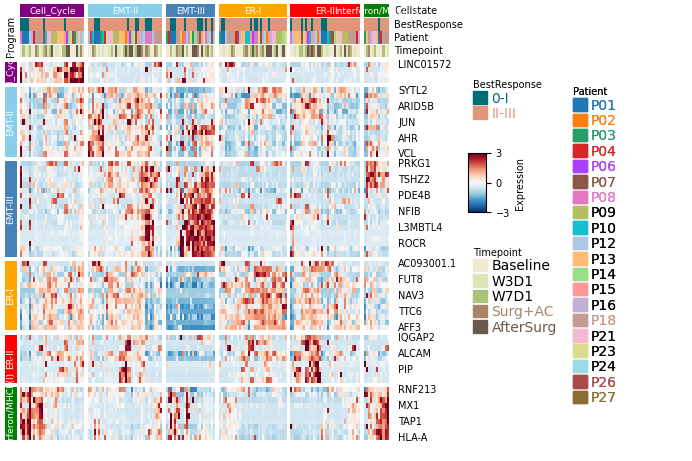

In [155]:
aggregate_heatmap(adata=tumor,
                  features=ref_ITH,
                  top_anno_columns=['Cellstate','BestResponse','Patient','Timepoint'],
                  col_split='Cellstate',
                  col_split_gap=1,
                  row_split='Program',
                  row_split_gap=1,
                  palette=palette,
                  figsize=(5,5),
                  vmax=3,vmin=-3,
                 )

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 30.516666666666666 mm


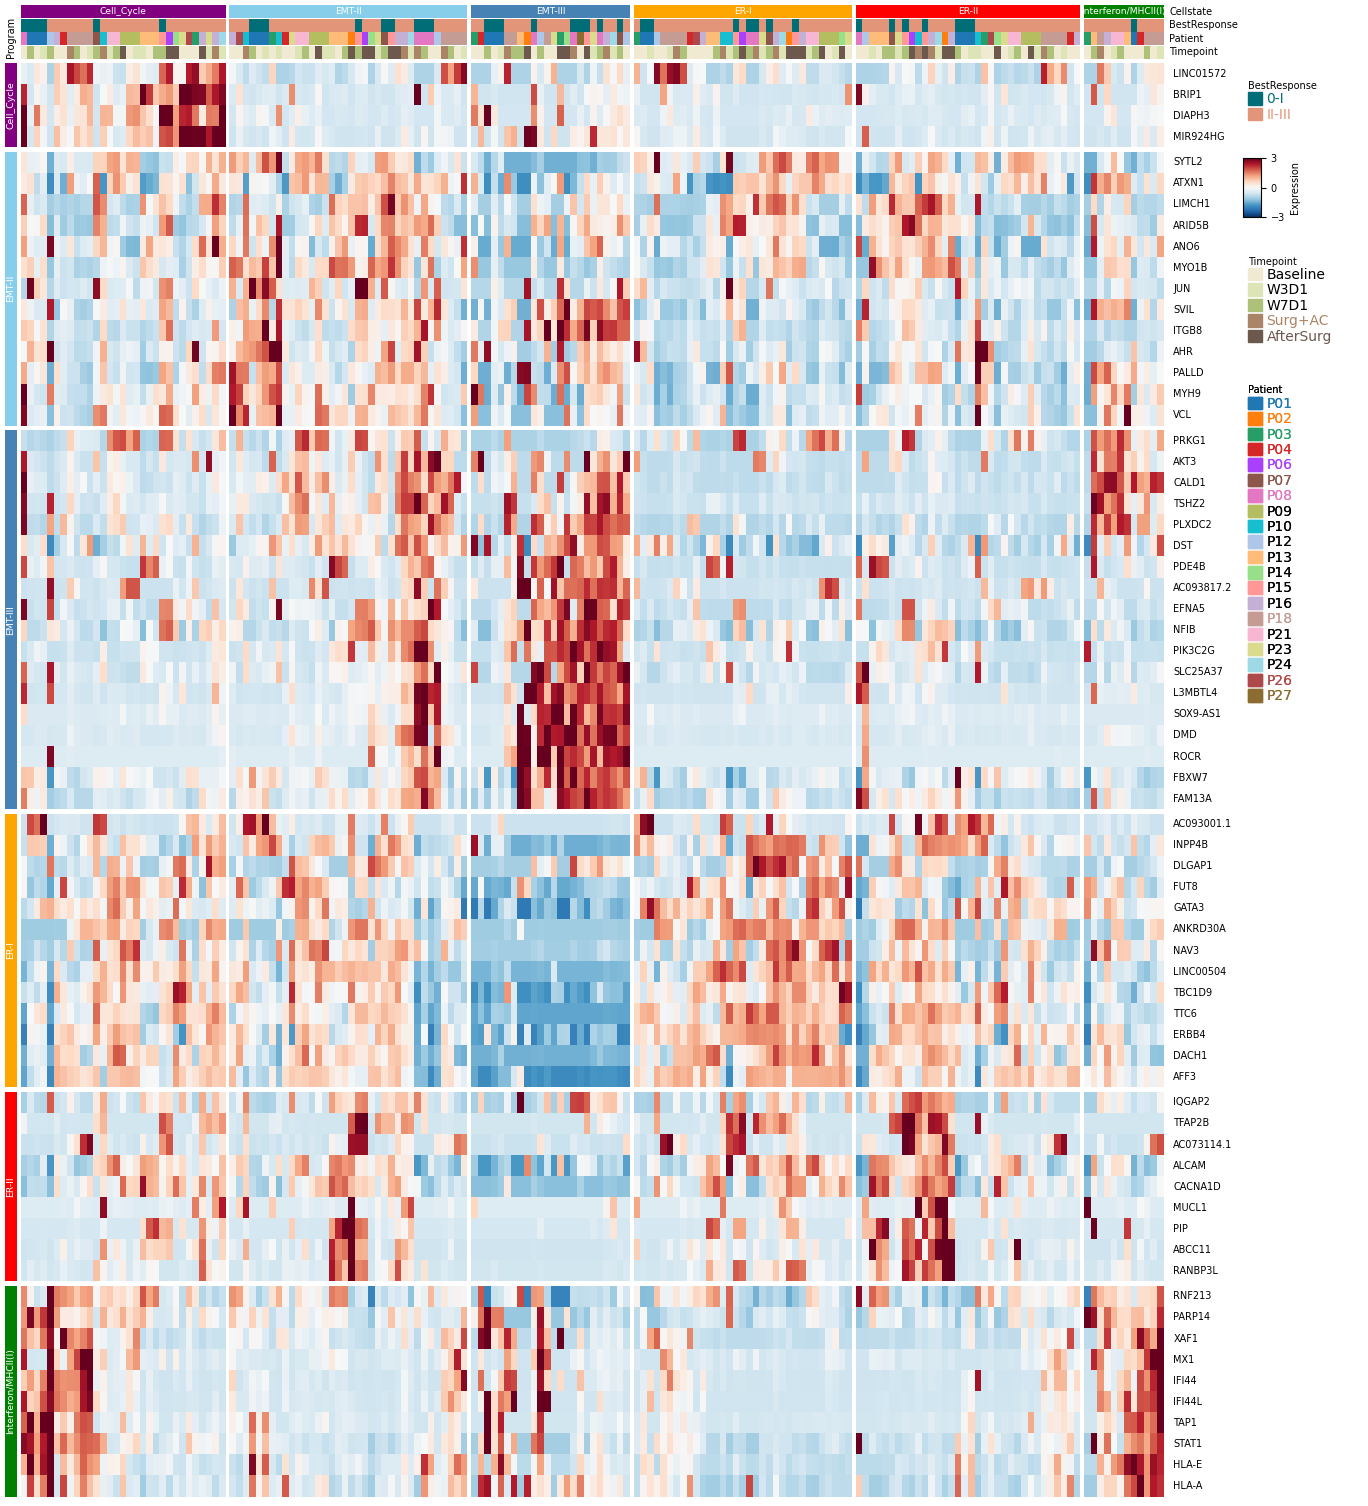

In [163]:
aggregate_heatmap(adata=tumor,
                  features=ref_ITH,
                  top_anno_columns=['Cellstate','BestResponse','Patient','Timepoint'],
                  col_split='Cellstate',
                  col_split_gap=1,
                  row_split='Program',
                  row_split_gap=1,
                  palette=palette,
                  figsize=(15,17),
                  vmax=3,vmin=-3,
                 )